# Se importan las librerías necesarias

In [93]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
import ast
import requests
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import word_tokenize



# Se cargan los datset solicitados

In [94]:
movie = pd.read_csv("datasets/movies_dataset.csv")
credits = pd.read_csv("datasets/credits.csv")

C:\Users\Sergio\AppData\Local\Temp\ipykernel_181620\2045859923.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movie = pd.read_csv("datasets/movies_dataset.csv")


# Visualizacion de los dataset

In [ ]:
movie

In [ ]:
credits.head()

In [ ]:
movie.dtypes

In [ ]:
credits.dtypes

# Desanidado de las columnas que contienen diccionarios o listas
En este caso en dicha columnas lo que hago es buscar los datos que voy a necesitar y los sobreescribo en la columna

In [95]:
# Funcion para extraer el nombre de la coleccion de las peliculas con franquicia
def coleccion(dato):
    if pd.notnull(dato):
        try:
            datos = eval(dato)
            nombre = datos['name']
            return (nombre)
        except (SyntaxError, KeyError, TypeError):
            pass  
    return dato
# Funcion para extrar los datos que necesito de las columnas genres, production_companies y production_countries
def extraer(datos):
    try:
        listaDatos = ast.literal_eval(datos)
        if isinstance(listaDatos, list):
            return [dato['name'] for dato in listaDatos]
    except (SyntaxError, ValueError):
        pass
    return []
    
movie['belongs_to_collection'] = movie['belongs_to_collection'].apply(coleccion)

columnas = ['genres','production_companies', 'production_countries']
for columna in columnas:
    movie[columna] = movie[columna].fillna('[]')
    movie[columna] = movie[columna].apply(extraer)

In [96]:
# De cast solo me interesan los nombres de los actores
def actor(casts):
    try:
        cast_list = eval(casts)  
        nombre = [cast['name'] for cast in cast_list]
        return nombre
    except (SyntaxError, ValueError):
        return []

credits['cast'] = credits['cast'].apply(actor)

In [97]:
# De crew solo me interesa el nombre del director
def director(crew):
    try:
        crew_list = eval(crew) 
        for member in crew_list:
            if member['job'] == 'Director':
                return member['name']
        return None  
    except (SyntaxError, ValueError):
        return None

credits['crew'] = credits['crew'].apply(director)

# Mostrar los DataFrames con los datos actualizados

In [ ]:
movie.head()

In [ ]:

credits.head()

In [98]:
# Rellenar los valores nulos de las columnas "revenue" y "budget" con el número 0
movie["revenue"].fillna(0, inplace=True)
movie["budget"].fillna(0, inplace=True)

In [99]:
# Convertir las columnas "budget" y "revenue" a valores numéricos
movie["budget"] = pd.to_numeric(movie["budget"], errors="coerce")
movie["revenue"] = pd.to_numeric(movie["revenue"], errors="coerce")

In [100]:
# Calcular el retorno de inversión y crear la columna 'return'
movie['return'] = movie['revenue'] / movie['budget']
movie['return'].fillna(0, inplace=True)  # Rellenar los valores NaN con 0
movie.replace([np.inf, -np.inf], 0, inplace=True)

In [101]:
# Eliminar los valores nulos en la columna "release_date"
movie.dropna(subset=["release_date"], inplace=True)

In [102]:
# Las fechas, deberán tener el formato AAAA-mm-dd, además se crea la columna release_year donde extraerán el año de la fecha de estreno.
movie["release_date"] = pd.to_datetime(movie["release_date"], errors="coerce").dt.strftime('%Y-%m-%d')
movie["release_year"] = pd.to_datetime(movie["release_date"], errors="coerce").dt.year
movie["release_year"] = movie["release_year"].astype(float).astype(pd.Int32Dtype())


In [103]:
# Columnas a eliminar
columnas_a_eliminar = ['video', 'imdb_id', 'adult', 'original_title', 'poster_path', 'homepage','spoken_languages']
movie.drop(columns=columnas_a_eliminar, inplace=True)

In [104]:
# Se crea el Dataset peliculas con la combinacion de movie y credits por el id
movie['id'] = movie['id'].astype(str)
credits['id'] = credits['id'].astype(str)
peliculas = pd.merge(movie, credits, on='id', how='inner')


In [ ]:
# Visualizacion del dataset peliculas
peliculas.head()

In [ ]:
peliculas.dtypes

In [105]:
# renombro algunas columnas para mejor comprencion y tambien cambio los tipos de variables en la que hace falta
peliculas.rename(columns={'belongs_to_collection': 'franquicia', 'production_companies': 'productora', 'production_countries': 'pais','original_language': 'idioma', 'spoken_languages': 'lenguajes_adicionales', 'tagline': 'eslogan', 'crew': 'director'}, inplace=True)

peliculas["id"] = peliculas["id"].astype(int)
peliculas["popularity"] = peliculas["popularity"].astype(float)
peliculas["vote_count"] = peliculas["vote_count"].astype(int)

# Limpieza adicional de datos

In [106]:
#cantidad de filas duplicadas 
peliculas.duplicated(subset='id').sum()

106

In [ ]:
#se revisan las filas con id duplicado
peliculas[peliculas.id.duplicated(keep=False)].sort_values(by="id") 

In [107]:
#se eliminan las filas con id duplicado conservando las últimas cargadas en la base
peliculas.drop_duplicates(subset="id", keep="last", inplace=True) 

In [ ]:
peliculas.info()

In [ ]:
#se revisa la cantidad de valores faltantes para cada feature
peliculas.isna().sum() 

In [108]:
# Limpiar el título de las películas para asegurar consistencia (opcional)
peliculas['title'] = peliculas['title'].str.strip()

# Crear una nueva columna 'recomendacion' en el dataset para almacenar las películas recomendadas
peliculas['recomendacion'] = ''

# Definir función para calcular la similitud entre películas
def calcular_similitud():
    # Crear una matriz TF-IDF para el título y el género de las películas
    tfidf = TfidfVectorizer(stop_words=stopwords.words('spanish'))
    peliculas['title'] = peliculas['title'].fillna('')
    peliculas['genres'] = peliculas['genres'].fillna('')
    peliculas['genres'] = peliculas['genres'].apply(lambda x: ' '.join(ast.literal_eval(x)) if isinstance(x, str) and x.startswith('[') else '')  # Convertir la lista de géneros a una cadena de texto

    tfidf_matrix = tfidf.fit_transform(peliculas['title'] + ' ' + peliculas['genres'])  # Concatenar título y géneros

    # Calcular la matriz de similitud coseno
    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

    # Crear un diccionario para almacenar las recomendaciones para cada película
    recommendations_dict = {}
    for idx, title in enumerate(peliculas['title']):
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:6]  # Top 5 películas similares (excluyendo la película en sí misma)
        movie_indices = [i[0] for i in sim_scores]

        # Usar un conjunto para evitar títulos duplicados en las recomendaciones
        recommendations = set(peliculas['title'].iloc[movie_indices].tolist())
        recommendations_dict[title] = recommendations

    return recommendations_dict


In [109]:
def recomendacion(titulo: str):
    try:
        print(f'Título ingresado: {titulo}')
        titulo = titulo.strip().lower()  # Eliminar espacios adicionales y convertir a minúsculas
        print(f'Título formateado: {titulo}')
        peliculas_filtradas = peliculas.loc[peliculas['title'].str.strip().str.lower() == titulo]

        if not peliculas_filtradas.empty:
            recomendaciones_set = set()

            # Obtener la franquicia del título ingresado
            franquicia_titulo = peliculas_filtradas.iloc[0]['franquicia']

            # Buscar otros títulos que pertenezcan a la misma franquicia
            if not pd.isna(franquicia_titulo):
                peliculas_misma_franquicia = peliculas[peliculas['franquicia'] == franquicia_titulo]
                for titulo_franquicia in peliculas_misma_franquicia['title']:
                    if titulo_franquicia.lower() != titulo:  # Evitar agregar el título ingresado a las recomendaciones
                        recomendaciones_set.add(titulo_franquicia)

            # Agregar las recomendaciones generales desde el diccionario de recomendaciones
            recomendaciones_generales = recommendations_dict.get(titulo, [])
            for titulo_recomendado in recomendaciones_generales:
                if titulo_recomendado.lower() != titulo:  # Evitar agregar el título ingresado a las recomendaciones
                    recomendaciones_set.add(titulo_recomendado)

            return list(recomendaciones_set)[:5]  # Limitar a 5 recomendaciones

        else:
            return ['Título no encontrado']

    except IndexError:
        return ['Título no encontrado']


# Llamar a la función calcular_similitud() para obtener las recomendaciones
recommendations_dict = calcular_similitud()

# Calcular y almacenar las recomendaciones en el DataFrame
peliculas['recomendacion'] = peliculas['title'].apply(lambda x: recommendations_dict[x])



In [110]:
peliculas

,franquicia,budget,genres,id,idioma,overview,popularity,productora,pais,release_date,...,status,eslogan,title,vote_average,vote_count,return,release_year,cast,director,recomendacion
0,Toy Story Collection,30000000.0,,862,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,[Pixar Animation Studios],[United States of America],1995-10-30,...,Released,NaN,Toy Story,7.7,5415,12.451801,1995,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...",John Lasseter,"{Toy Story 2, The Toy, Toy Story 3, Toy Story ..."
1,NaN,65000000.0,,8844,en,When siblings Judy and Peter discover an encha...,17.015539,"[TriStar Pictures, Teitler Film, Interscope Co...",[United States of America],1995-12-15,...,Released,Roll the dice and unleash the excitement!,Jumanji,6.9,2413,4.043035,1995,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...",Joe Johnston,"{Waiting to Exhale, Toy Story, Grumpier Old Me..."
2,Grumpy Old Men Collection,0.0,,15602,en,A family wedding reignites the ancient feud be...,11.712900,"[Warner Bros., Lancaster Gate]",[United States of America],1995-12-22,...,Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,6.5,92,0.000000,1995,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...",Howard Deutch,"{No Country for Old Men, T-Men, Old Men: Robbe..."
3,NaN,16000000.0,,31357,en,"Cheated on, mistreated and stepped on, the wom...",3.859495,[Twentieth Century Fox Film Corporation],[United States of America],1995-12-22,...,Released,Friends are the people who let you be yourself...,Waiting to Exhale,6.1,34,5.090760,1995,"[Whitney Houston, Angela Bassett, Loretta Devi...",Forest Whitaker,"{The Waiting Game, I Am Waiting, Crazy Waiting..."
4,Father of the Bride Collection,0.0,,11862,en,Just when George Banks has recovered from his ...,8.387519,"[Sandollar Productions, Touchstone Pictures]",[United States of America],1995-02-10,...,Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,5.7,173,0.000000,1995,"[Steve Martin, Diane Keaton, Martin Short, Kim...",Charles Shyer,"{The Bride, Son of the Bride, Father of the Br..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45446,NaN,0.0,,30840,en,"Yet another version of the classic epic, with ...",5.683753,"[Westdeutscher Rundfunk (WDR), Working Title F...","[Canada, Germany, United Kingdom, United State...",1991-05-13,...,Released,NaN,Robin Hood,5.7,26,0.000000,1991,"[Patrick Bergin, Uma Thurman, David Morrissey,...",John Irvin,"{The Adventures of Robin Hood, The Last of Rob..."
45447,NaN,0.0,,111109,tl,An artist struggles to finish his work while a...,0.178241,[Sine Olivia],[Philippines],2011-11-17,...,Released,NaN,Century of Birthing,9.0,3,0.000000,2011,"[Angel Aquino, Perry Dizon, Hazel Orencio, Joe...",Lav Diaz,"{Deal of the Century, The Children of the Cent..."
45448,NaN,0.0,,67758,en,"When one of her hits goes wrong, a professiona...",0.903007,[American World Pictures],[United States of America],2003-08-01,...,Released,A deadly game of wits.,Betrayal,3.8,6,0.000000,2003,"[Erika Eleniak, Adam Baldwin, Julie du Page, J...",Mark L. Lester,"{Samurai X: Trust & Betrayal, Betrayal, The Ar..."
45449,NaN,0.0,,227506,en,"In a small town live two brothers, one a minis...",0.003503,[Yermoliev],[Russia],1917-10-21,...,Released,NaN,Satan Triumphant,0.0,0,0.000000,1917,"[Iwan Mosschuchin, Nathalie Lissenko, Pavel Pa...",Yakov Protazanov,"{Satan's Sword, Satan, Satan Lives, Satan's Bl..."


In [127]:
def recomendaciones(titulo: str):
    try:
        recomendaciones = peliculas.loc[peliculas['title'] == titulo, 'recomendacion'].iloc[0]
        return recomendaciones if isinstance(recomendaciones, list) else 'No hay recomendación disponible'
    except IndexError:
        return 'Título no encontrado'
recomendacion_toy_story = recomendaciones('Toy Story')
print(recomendacion_toy_story)


['Toy Story 2', 'Toy Story 3', 'The Toy', 'The Toy', 'Toy Story of Terror!']


In [52]:
# Reemplazar valores NaN por cadenas vacías en las columnas relevantes
peliculas['franquicia'].fillna('', inplace=True)
peliculas['genres'].fillna('', inplace=True)
peliculas['title'].fillna('', inplace=True)
peliculas['overview'].fillna('', inplace=True)

# Convertir cada lista en una cadena antes de la concatenación
peliculas['franquicia'] = peliculas['franquicia'].apply(lambda x: ' '.join(x))
peliculas['genres'] = peliculas['genres'].apply(lambda x: ' '.join(x))

# Concatenamos las características relevantes en un solo campo para el análisis TF-IDF
peliculas['combined_features'] = peliculas['franquicia'] + ' ' + peliculas['genres']

# Creamos una matriz TF-IDF con las características de todas las películas
tfidf = TfidfVectorizer(stop_words='english')
features_matrix = tfidf.fit_transform(peliculas['combined_features'].fillna(''))

# Calcular la similitud de coseno entre las características de todas las películas
cosine_sim = linear_kernel(features_matrix, features_matrix)

indices = pd.Series(peliculas.index, index=peliculas['title']).drop_duplicates()

# Definir endpoint para obtener recomendaciones de películas por características
def recomendacion(titulo):
    try:
        idx = indices[indices.index == titulo].iloc[0]
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:6]
        movie_indices = [i[0] for i in sim_scores]
        movie_titles = peliculas.iloc[movie_indices]['title'].tolist()
        return movie_titles
    except KeyError:
        return {'message': f'No se encuentra la película "{titulo}" en el conjunto de datos'}
    except IndexError:
        return {'message': f'No se pudo obtener la recomendación para la película "{titulo}"'}

KeyError: 'franquicia'

In [55]:
# Add the franquicia column
peliculas['franquicia'] = ''

# Convertir cada lista en una cadena antes de la concatenación
peliculas['franquicia'] = peliculas['franquicia'].apply(lambda x: ' '.join(x))
peliculas['genres'] = peliculas['genres'].apply(lambda x: ' '.join(x))

# Concatenamos las características relevantes en un solo campo para el análisis TF-IDF
peliculas['combined_features'] = peliculas['franquicia'] + ' ' + peliculas['genres']

# Creamos una matriz TF-IDF con las características de todas las películas
tfidf = TfidfVectorizer(stop_words='english')
features_matrix = tfidf.fit_transform(peliculas['combined_features'].fillna(''))

# Calcular la similitud de coseno entre las características de todas las películas
cosine_sim = linear_kernel(features_matrix, features_matrix)

indices = pd.Series(peliculas.index, index=peliculas['title']).drop_duplicates()

# Definir endpoint para obtener recomendaciones de películas por características
def recomendacion(titulo):
    try:
        idx = indices[indices.index == titulo].iloc[0]
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:6]
        movie_indices = [i[0] for i in sim_scores]
        movie_titles = peliculas.iloc[movie_indices]['title'].tolist()
        return movie_titles
    except KeyError:
        return {'message': f'No se encuentra la película "{titulo}" en el conjunto de datos'}
    except IndexError:
        return {'message': f'No se pudo obtener la recomendación para la película "{titulo}"'}

if __name__ == '__main__':
    titulo = 'Spider-Man: No Way Home'
    recomendaciones = recomendacion(titulo)
    print(f'Las 5 recomendaciones para la película "{titulo}" son: {recomendaciones}')



ValueError: empty vocabulary; perhaps the documents only contain stop words

In [82]:
#Para la siguiente función se utiliza un df filtrado según un criterio de popularidad para reducir los tiempos de procesamiento
df_sample = peliculas[peliculas.popularity>1.130300].copy()

# Resetear los índices
df_sample.reset_index(drop=True, inplace=True)

# Calcular tfidf_matrix
tfidf = TfidfVectorizer(stop_words='english')
df_sample['overview'].fillna('', inplace=True) #se rellenan los valores faltantes
tfidf_matrix = tfidf.fit_transform(df_sample['title']+' '+df_sample['overview']) #se seleccionan las columnas para calcular la matriz

# Calcular matriz de similaridad coseno
print("comienza el calculo de la matriz")
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Extraer indices
indices = pd.Series(df_sample.index, index=df_sample['title']).drop_duplicates()

comienza el calculo de la matriz


In [83]:
def preprocess_text(text):
    # Convertir a minúsculas
    text = text.lower()
    # Eliminar caracteres no alfabéticos
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    # Tokenizar el texto en palabras
    words = word_tokenize(text)
    # Eliminar palabras de detención
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # Unir las palabras nuevamente en un texto preprocesado
    preprocessed_text = ' '.join(words)
    return preprocessed_text

# Aplicar el preprocesamiento a las columnas 'title' y 'overview'
df_sample['title'] = df_sample['title'].apply(preprocess_text)
df_sample['overview'] = df_sample['overview'].apply(preprocess_text)

# Calcular la matriz TF-IDF
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df_sample['title'] + ' ' + df_sample['overview'])

In [84]:
def get_recommendations(title:str, cosine_sim=cosine_sim):
    print(title)
    try:
        idx = indices[indices.index == title][0]
        # try:
        #   idx = indices[title][0]
        # except:
        #   idx = indices[title]
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:6]
        movie_indices = [i[0] for i in sim_scores]
        print(movie_indices)
        return str(df_sample['title'].iloc[movie_indices].tolist()) # se devuelve en formato str
        #return movie_indices
    except KeyError:
        print(f'No se encuentra el título {title} en el conjunto de datos')
        return []
    except IndexError:
        print(f'El índice {idx} no existe en cosine_sim')
        return []

In [88]:
peliculas['recs'] = [["Debido a la baja popularidad del título consultado no es posible identificar películas para recomendar."]] * len(peliculas)



In [89]:
peliculas.loc[peliculas.popularity>1.130300,'recs'] = peliculas[peliculas.popularity>1.130300]['title'].apply(get_recommendations) #se agregan las recomendaciones para cada título

Toy Story
[11321, 2408, 7974, 15502, 6554]
Jumanji
[14178, 19601, 17935, 4924, 20831]
Grumpier Old Men
[7205, 3296, 367, 15537, 9479]
Waiting to Exhale
[20743, 11599, 12149, 12896, 21040]
Father of the Bride Part II
[5397, 22209, 5038, 14842, 5230]
Heat
[14462, 12307, 7787, 11509, 7698]
Sabrina
[8942, 22501, 299, 15589, 3295]
Tom and Huck
[9788, 1422, 16535, 452, 500]
Sudden Death
[10050, 10818, 10825, 17955, 4151]
GoldenEye
[5027, 2304, 6558, 5830, 5826]
The American President
[12234, 12064, 268, 9641, 9150]
Dracula: Dead and Loving It
[1017, 14132, 5795, 2019, 4443]
Balto
[12981, 18831, 19148, 12746, 3484]
Nixon
[2116, 10116, 7447, 20103, 17134]
Cutthroat Island
[4496, 21902, 8988, 15006, 10626]
Casino
[12629, 16820, 14358, 9800, 24]
Sense and Sensibility
[20882, 8154, 9584, 6575, 21492]
Four Rooms
[17448, 17780, 1404, 12788, 6520]
Ace Ventura: When Nature Calls
[4541, 17809, 284, 11601, 16193]
Money Train
[13125, 17686, 13227, 4102, 3559]
Get Shorty
[7590, 20528, 3177, 18063, 7234]


In [90]:
peliculas.sample(10) #se revisa el resultado

,franquicia,budget,genres,id,idioma,overview,popularity,productora,pais,release_date,...,status,eslogan,title,vote_average,vote_count,return,release_year,cast,director,recs
36996,NaN,0.0,[Animation],351981,es,An old bear goes out every day to a busy stree...,1.775444,[Punkrobot],[Chile],2014-06-09,...,Released,NaN,Bear Story,7.8,30,0.000000,2014,[],Gabriel Osorio,"['bear', 'ordinary miracle', 'ted', 'gold digg..."
6273,NaN,275000.0,"[Action, Horror, Thriller]",29425,en,Citizens of a small town are infected by a bio...,3.739226,[Pittsburgh Films],[United States of America],1973-03-16,...,Released,All hell is about to break loose.,The Crazies,6.0,67,0.000000,1973,"[Lane Carroll, Will MacMillan, Harold Wayne Jo...",George A. Romero,"['crazies', 'vizontele', 'silent night', 'bree..."
13648,NaN,0.0,[Documentary],128857,en,Apollo 13: To the Edge and Back tells the grip...,0.002384,[],[],1994-01-01,...,Released,A detailed account of the trials and triumphs ...,Apollo 13: To the Edge and Back,0.0,0,0.000000,1994,"[Jim Lovell, Fred Haise, Gene Kranz, Jack Swik...",None,[Debido a la baja popularidad del título consu...
14919,NaN,14000000.0,"[Action, Comedy]",12273,hi,"A comic caper about Happy Singh, a Punjabi vil...",1.369086,[Reliance Entertainment],[India],2008-01-01,...,Released,Summer 2008: The gang of Punjab arrives with a...,Singh Is Kinng,5.3,22,1.785714,2008,"[Akshay Kumar, Katrina Kaif, Om Puri, Ranvir S...",Anees Bazmee,"['paan singh tomar', 'rocket singh salesman ye..."
1854,NaN,5500000.0,"[Drama, History]",9443,en,The true story of British athletes preparing f...,6.877698,"[Twentieth Century Fox Film Corporation, Warne...",[United Kingdom],1981-05-15,...,Released,"This is the story of two men who run, not to r...",Chariots of Fire,6.9,213,10.722346,1981,"[Ben Cross, Ian Charleson, Cheryl Campbell, Al...",Hugh Hudson,"['summer turned', 'cat meow', 'walk run', 'per..."
41350,NaN,0.0,"[Music, Drama]",413588,hi,The musical drama is a sequel to the 2008 bloc...,0.212306,"[Excel Entertainment, Eros International]",[India],2016-11-11,...,Released,Every generation finds its voice.,Rock On 2,3.5,4,0.000000,2016,"[Shraddha Kapoor, Arjun Rampal, Farhan Akhtar,...",Shujaat Saudagar,[Debido a la baja popularidad del título consu...
45035,NaN,0.0,"[Comedy, Drama]",348391,en,Frustrated by the hypocrisy they see in their ...,1.506112,[Sycamore Pictures],[United States of America],2017-04-07,...,Released,Life is a stage. Find your voice. Change the w...,Speech & Debate,6.3,13,0.000000,2017,"[Liam James, Sarah Steele, Austin P. McKenzie,...",Dan Harris,"['mac devin go high school', 'lower learning',..."
19980,NaN,0.0,[Action],91333,en,A cop turns vigilante after his family is murd...,1.614314,"[NGN Productions, Nasser Group, North, Caliber...",[Canada],2011-01-01,...,Released,NaN,Recoil,5.0,34,0.000000,2011,"[Danny Trejo, Serinda Swan, Steve Austin, Loch...",Terry Miles,"['samurai cop deadly vengeance', 'vengeance', ..."
29359,NaN,0.0,"[Animation, Comedy, War]",208333,en,Somewhat based on Desmond Morris's fascinating...,0.061539,"[Universal Pictures, Playboy Enterprises, Jenn...",[United States of America],1973-08-01,...,Released,The naked ape is only human.,The Naked Ape,5.0,1,0.000000,1973,"[Johnny Crawford, Victoria Principal, Norm Gra...",Donald Driver,[Debido a la baja popularidad del título consu...
27998,NaN,0.0,[Drama],88599,es,"Karen discovers, after 10 years of marriage, s...",0.148442,[],[Colombia],2011-05-13,...,Released,NaN,Karen Cries on the Bus,7.5,4,0.000000,2011,"[Angela Carrizosa, Juan Manuel Diaz Oroztegui,...",Gabriel Rojas Vera,[Debido a la baja popularidad del título consu...


In [111]:
recomendaciones = peliculas('Toy Story')
recomendaciones

TypeError: 'DataFrame' object is not callable

In [112]:
peliculas.to_csv("datasets/peliculas.csv", index=False)

In [133]:
import pandas as pd
import ast
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Cargar el conjunto de datos
peliculas = pd.read_csv("datasets/movies_dataset.csv")

# Limpiar el título de las películas para asegurar consistencia (opcional)
peliculas['title'] = peliculas['title'].str.strip()

# Crear una nueva columna 'recomendacion' en el dataset para almacenar las películas recomendadas
peliculas['recomendacion'] = ''

# Definir función para calcular la similitud entre películas
def convert_to_list_or_dict(x):
    try:
        return ast.literal_eval(x)
    except (SyntaxError, ValueError):
        return x

def calcular_similitud():
    # Crear una matriz TF-IDF para el título y el género de las películas
    tfidf = TfidfVectorizer(stop_words=stopwords.words('spanish'))
    peliculas['title'] = peliculas['title'].fillna('')
    peliculas['genres'] = peliculas['genres'].fillna('')

    # Ahora, para cada fila que tenga un diccionario, vamos a tomar los valores y convertirlos a una lista
    for idx, row in peliculas.iterrows():
        if isinstance(row['genres'], dict):
            peliculas.at[idx, 'genres'] = list(row['genres'].values())

    # Convertir los géneros a una cadena de texto
    peliculas['genres_str'] = peliculas['genres'].apply(lambda x: ' '.join(x) if isinstance(x, list) else '')

    tfidf_matrix = tfidf.fit_transform(peliculas['title'] + ' ' + peliculas['genres_str'])  # Concatenar título y géneros
    # Calcular la matriz de similitud coseno
    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

    # Crear un diccionario para almacenar las recomendaciones para cada película
    recommendations_dict = {}
    for idx, title in enumerate(peliculas['title']):
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:6]  # Top 5 películas similares (excluyendo la película en sí misma)
        movie_indices = [i[0] for i in sim_scores]

        # Usar una lista para almacenar las recomendaciones
        recommendations = peliculas['title'].iloc[movie_indices].tolist()
        if title in recommendations:
            recommendations.remove(title)  # Eliminar la película en sí misma de las recomendaciones
        recommendations_dict[title] = recommendations

    return recommendations_dict


# Llamar a la función calcular_similitud() para obtener las recomendaciones
recommendations_dict = calcular_similitud()

# Calcular y almacenar las recomendaciones en el DataFrame
peliculas['recomendacion'] = peliculas['title'].apply(lambda x: recommendations_dict[x])

# Mover el cálculo de recomendaciones al inicio del script
recommendations_dict = calcular_similitud()

# Definir función para obtener las recomendaciones de una película
def obtener_recomendaciones(titulo: str):
    try:
        recomendaciones_set = set()

        # Paso 1: Obtener la franquicia del título ingresado
        peliculas_filtradas = peliculas[peliculas['title'] == titulo]
        franquicia_titulo = peliculas_filtradas.iloc[0]['franquicia']

        # Buscar otros títulos que pertenezcan a la misma franquicia
        if not pd.isna(franquicia_titulo):
            peliculas_misma_franquicia = peliculas[peliculas['franquicia'] == franquicia_titulo]
            for titulo_franquicia in peliculas_misma_franquicia['title']:
                if titulo_franquicia.lower() != titulo.lower():
                    recomendaciones_set.add(titulo_franquicia)

        # Paso 2: Obtener películas con géneros similares
        generos_titulo = peliculas_filtradas.iloc[0]['genres']
        if isinstance(generos_titulo, str):
            generos_titulo = ast.literal_eval(generos_titulo)
            peliculas_mismos_generos = peliculas[peliculas['genres'].apply(lambda x: set(generos_titulo).issubset(ast.literal_eval(x)) if isinstance(x, str) else False)]
            for titulo_genero in peliculas_mismos_generos['title']:
                if titulo_genero.lower() != titulo.lower() and titulo_genero not in recomendaciones_set:
                    recomendaciones_set.add(titulo_genero)

        # Paso 3: Obtener películas con popularidad similar o superior
        popularidad_titulo = peliculas_filtradas.iloc[0]['popularity']
        if not pd.isna(popularidad_titulo):
            peliculas_populares = peliculas[peliculas['popularity'] >= popularidad_titulo]
            for titulo_popular in peliculas_populares['title']:
                if titulo_popular.lower() != titulo.lower() and titulo_popular not in recomendaciones_set:
                    recomendaciones_set.add(titulo_popular)

        # Completar con recomendaciones generales hasta llegar a 5 títulos
        recomendaciones_generales = recommendations_dict.get(titulo, [])
        for titulo_recomendado in recomendaciones_generales:
            if len(recomendaciones_set) == 5:
                break
            if titulo_recomendado.lower() != titulo.lower() and titulo_recomendado not in recomendaciones_set:
                recomendaciones_set.add(titulo_recomendado)

        return list(recomendaciones_set)

    except IndexError:
        return ['Título no encontrado']

# Ejemplo de uso
recomendacion_toy_story = obtener_recomendaciones('Toy Story')
print(recomendacion_toy_story)

C:\Users\Sergio\AppData\Local\Temp\ipykernel_7832\3724697853.py:8: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  peliculas = pd.read_csv("datasets/movies_dataset.csv")


KeyError: 'franquicia'

In [64]:
peliculas.dtypes

franquicia       object
budget          float64
genres           object
idioma           object
overview         object
popularity      float64
productora       object
pais             object
revenue         float64
runtime          object
title            object
return          float64
release_year      Int32
cast             object
director         object
dtype: object

In [65]:
peliculas.to_csv("datasets/peliculas.csv", index=False)

# Análisis exploratorio de los datos:

In [154]:
# Estadísticas descriptivas para columnas numéricas
peliculas.describe()

,budget,id,popularity,revenue,vote_average,vote_count,return,release_year
count,4.534500e+04,45345.000000,45345.000000,4.534500e+04,45345.000000,45345.000000,4.534500e+04,45345.000000
mean,4.232673e+06,108035.740479,2.926052,1.123390e+07,5.624320,110.137766,6.604937e+02,1991.882280
std,1.744391e+07,112180.079341,6.010770,6.441058e+07,1.915178,491.904429,7.471882e+04,24.053016
min,0.000000e+00,2.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,1874.000000
25%,0.000000e+00,26390.000000,0.388844,0.000000e+00,5.000000,3.000000,0.000000e+00,1978.000000
50%,0.000000e+00,59852.000000,1.130300,0.000000e+00,6.000000,10.000000,0.000000e+00,2001.000000
75%,0.000000e+00,156597.000000,3.689610,0.000000e+00,6.800000,34.000000,0.000000e+00,2010.000000
max,3.800000e+08,469172.000000,547.488298,2.787965e+09,10.000000,14075.000000,1.239638e+07,2020.000000


C:\Users\Sergio\AppData\Local\Temp\ipykernel_12176\1419290655.py:10: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  idiomas_frecuentes = top_idiomas.append(otros_idiomas)


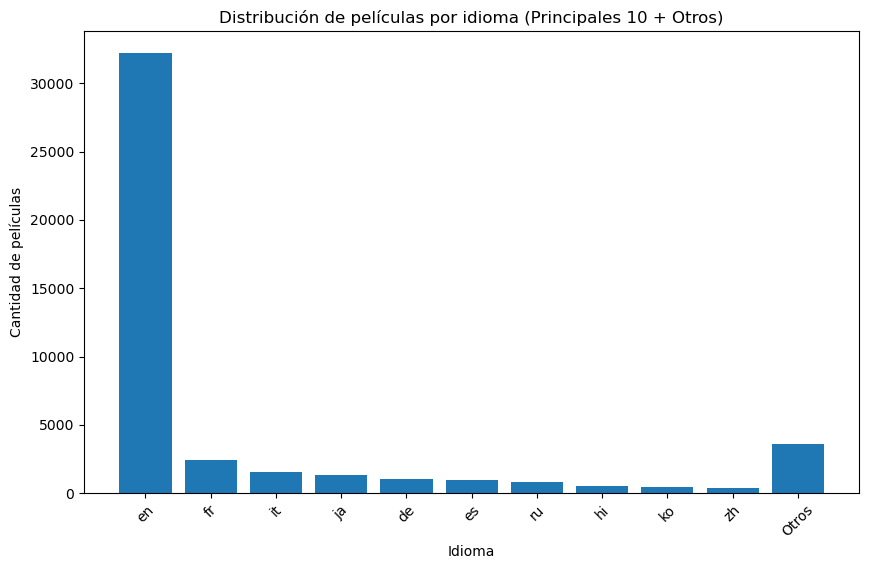

In [162]:
# Visualización de la distribución de películas por idioma con agrupación de idiomas menos frecuentes en "Otros"
idioma_counts = peliculas['idioma'].value_counts()

# Establecer el número de idiomas principales a mostrar
num_top_idiomas = 10

# Obtener los idiomas más frecuentes y agrupar el resto en "Otros"
top_idiomas = idioma_counts[:num_top_idiomas]
otros_idiomas = pd.Series(idioma_counts[num_top_idiomas:].sum(), index=['Otros'])
idiomas_frecuentes = top_idiomas.append(otros_idiomas)

plt.figure(figsize=(10, 6))
plt.bar(idiomas_frecuentes.index, idiomas_frecuentes.values)
plt.xlabel('Idioma')
plt.ylabel('Cantidad de películas')
plt.title(f'Distribución de películas por idioma (Principales {num_top_idiomas} + Otros)')
plt.xticks(rotation=45)
plt.show()


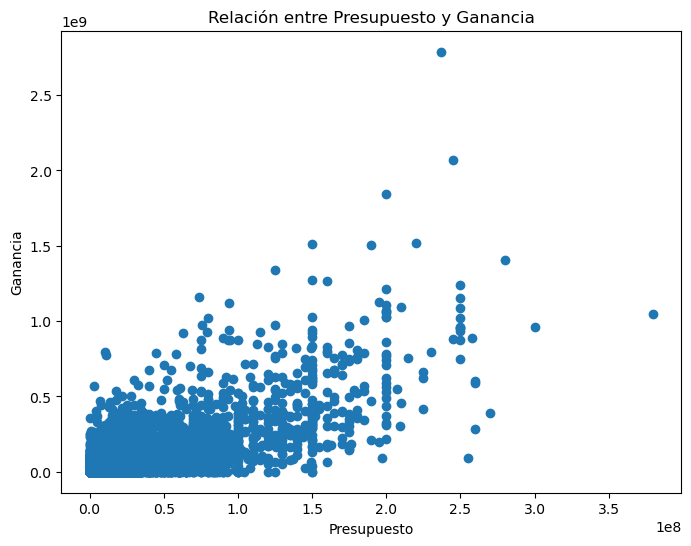

In [156]:
# Visualización de la relación entre presupuesto y ganancia
plt.figure(figsize=(8, 6))
plt.scatter(peliculas['budget'], peliculas['revenue'])
plt.xlabel('Presupuesto')
plt.ylabel('Ganancia')
plt.title('Relación entre Presupuesto y Ganancia')
plt.show()


In [160]:
%pip install wordcloud

  Using cached wordcloud-1.9.2-cp39-cp39-win_amd64.whl (153 kB)
Note: you may need to restart the kernel to use updated packages.


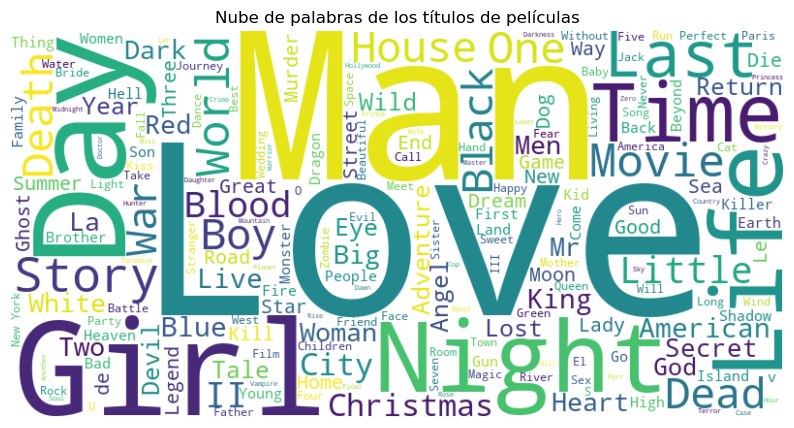

In [161]:
from wordcloud import WordCloud

# Concatenar todos los títulos en un solo texto
all_titles = ' '.join(peliculas['title'])

# Crear una nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_titles)

# Visualización de la nube de palabras
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras de los títulos de películas')
plt.show()


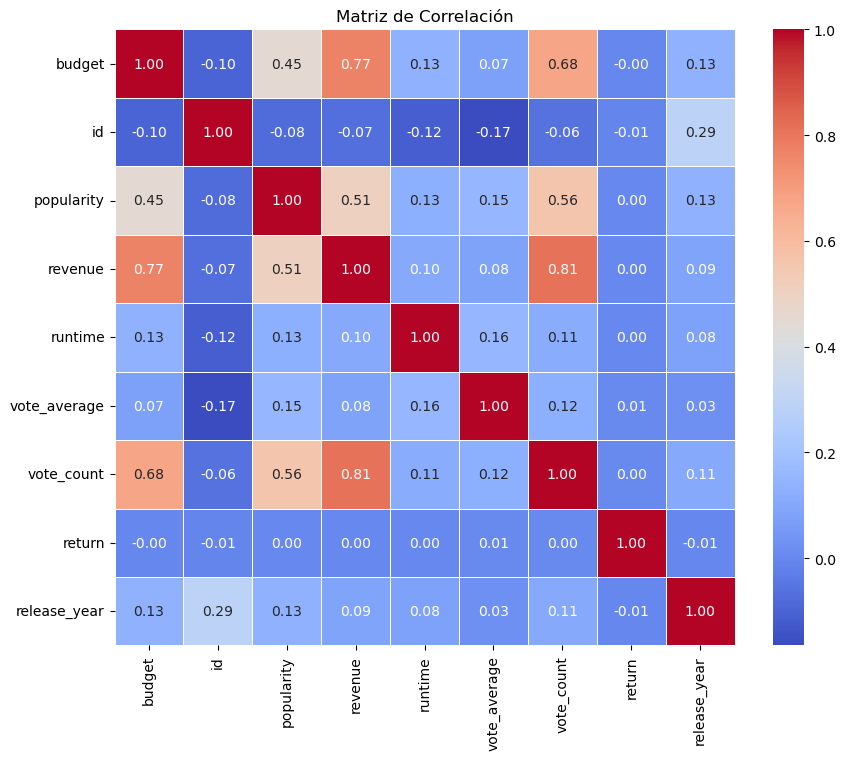

In [163]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Cargar el dataset "peliculas"
peliculas = pd.read_csv('datasets/peliculas.csv')

# Reemplazar valores NaN por cadenas vacías en las columnas relevantes
peliculas['franquicia'].fillna('', inplace=True)
peliculas['genres'].fillna('', inplace=True)
peliculas['idioma'].fillna('', inplace=True)
peliculas['eslogan'].fillna('', inplace=True)

# Crear la matriz de correlación
matriz_correlacion = peliculas.corr()

# Visualizar la matriz de correlación en un mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()


In [164]:
import pandas as pd

# Cargar el dataset "peliculas"
peliculas = pd.read_csv('datasets/peliculas.csv')

# Reemplazar valores NaN por cadenas vacías en las columnas relevantes
peliculas['franquicia'].fillna('', inplace=True)
peliculas['genres'].fillna('', inplace=True)
peliculas['idioma'].fillna('', inplace=True)
peliculas['eslogan'].fillna('', inplace=True)

# Crear la matriz de correlación
matriz_correlacion = peliculas.corr()

# Imprimir la matriz de correlación
print(matriz_correlacion)


                budget        id  popularity   revenue   runtime  \
budget        1.000000 -0.101274    0.449590  0.768811  0.134706   
id           -0.101274  1.000000   -0.082435 -0.070987 -0.119359   
popularity    0.449590 -0.082435    1.000000  0.506203  0.129628   
revenue       0.768811 -0.070987    0.506203  1.000000  0.103969   
runtime       0.134706 -0.119359    0.129628  0.103969  1.000000   
vote_average  0.073159 -0.165114    0.153714  0.083811  0.156642   
vote_count    0.676668 -0.064514    0.559973  0.812019  0.113527   
return       -0.002137 -0.006759    0.003216  0.000791  0.000891   
release_year  0.131654  0.286999    0.131637  0.088364  0.078778   

              vote_average  vote_count    return  release_year  
budget            0.073159    0.676668 -0.002137      0.131654  
id               -0.165114   -0.064514 -0.006759      0.286999  
popularity        0.153714    0.559973  0.003216      0.131637  
revenue           0.083811    0.812019  0.000791      0.088

In [165]:
import pandas as pd

# Cargar el dataset "peliculas" si aún no lo tienes cargado
peliculas = pd.read_csv('datasets/peliculas.csv')

# Crear la tabla de contingencia entre franquicia y género
tabla_contingencia = pd.crosstab(peliculas['franquicia'], peliculas['genres'])

# Visualizar la tabla de contingencia
print(tabla_contingencia)


genres                                ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime']  \
franquicia                                                                                      
... Has Fallen Collection                                                             0         
00 Schneider Filmreihe                                                                0         
08/15 Collection                                                                      0         
100 Girls Collection                                                                  0         
101 Dalmatians (Animated) Collection                                                  0         
...                                                                                 ...         
Сказки Чуковского                                                                     0         
Чебурашка и крокодил Гена                                                             0         
Что Творят мужчины! (Коллекция

In [88]:
peliculas.dtypes

franquicia       object
budget          float64
genres           object
id                int32
idioma           object
overview         object
popularity      float64
productora       object
pais             object
revenue         float64
runtime          object
title            object
vote_average    float64
vote_count        int32
return          float64
release_year      Int32
cast             object
director         object
dtype: object

In [70]:
peliculas_procesadas

,id,title,franquicia,genres
0,862,Toy Story,Toy Story Collection,"['Animation', 'Comedy', 'Family']"
1,8844,Jumanji,,"['Adventure', 'Fantasy', 'Family']"
2,15602,Grumpier Old Men,Grumpy Old Men Collection,"['Romance', 'Comedy']"
3,31357,Waiting to Exhale,,"['Comedy', 'Drama', 'Romance']"
4,11862,Father of the Bride Part II,Father of the Bride Collection,['Comedy']
...,...,...,...,...
45446,30840,Robin Hood,,"['Drama', 'Action', 'Romance']"
45447,111109,Century of Birthing,,['Drama']
45448,67758,Betrayal,,"['Action', 'Drama', 'Thriller']"
45449,227506,Satan Triumphant,,[]


In [81]:
# Crear un nuevo DataFrame con las columnas deseadas y las primeras 1000 filas del DataFrame original
peliculas_procesadas = peliculas[['id', 'title', 'franquicia', 'genres']].head(1000)

# Mostrar el nuevo DataFrame
peliculas_procesadas


,id,title,franquicia,genres
0,862,Toy Story,Toy Story Collection,"['Animation', 'Comedy', 'Family']"
1,8844,Jumanji,,"['Adventure', 'Fantasy', 'Family']"
2,15602,Grumpier Old Men,Grumpy Old Men Collection,"['Romance', 'Comedy']"
3,31357,Waiting to Exhale,,"['Comedy', 'Drama', 'Romance']"
4,11862,Father of the Bride Part II,Father of the Bride Collection,['Comedy']
...,...,...,...,...
1004,29682,So Dear to My Heart,,"['Animation', 'Drama', 'Family']"
1005,8367,Robin Hood: Prince of Thieves,,['Adventure']
1006,433,Mary Poppins,,"['Comedy', 'Family', 'Fantasy']"
1007,11360,Dumbo,,"['Animation', 'Family']"
